# 🧠 Brain Tumor Segmentation with BraTS2020 Dataset

### Project Overview
This notebook implements 3D brain tumor segmentation using the BraTS2020 dataset and a 3D U-Net architecture. The workflow includes:

1. **Data Configuration & Exploration** - Setup paths and explore the dataset structure
2. **Data Visualization** - Visualize MRI modalities and segmentation masks
3. **Data Preprocessing** - Normalize, scale, and combine MRI channels
4. **Train/Validation Split** - Split data for training and validation
5. **Custom Data Generator** - Create efficient data loading with augmentation
6. **3D U-Net Architecture** - Build the segmentation model
7. **Model Training** - Train with checkpoints and early stopping
8. **Model Evaluation** - Calculate DICE scores and visualize results
9. **Predictions** - Generate and visualize segmentation predictions

In [ ]:
pip install segmentation-models-3D

In [ ]:
# Import essential libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NIfTI file handling
import nibabel as nib
import glob
import random
from tqdm import tqdm

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, concatenate, 
                                   Conv3DTranspose, BatchNormalization, Dropout, 
                                   Lambda, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import segmentation_models_3D as sm

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## 1. Data Configuration

Setting up paths for the BraTS2020 dataset on Kaggle. We use optimal storage management:
- **Temporary storage** (`/tmp/`) for large processed data (~100GB capacity)
- **Working directory** (`/kaggle/working/`) for final models and outputs (~20GB capacity)

In [6]:
# Configure dataset paths for Kaggle environment
KAGGLE_INPUT_PATH = "/kaggle/input/brats20-dataset-training-validation/"
TRAIN_DATASET_PATH = KAGGLE_INPUT_PATH + "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
VAL_DATASET_PATH = KAGGLE_INPUT_PATH + "BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

In [7]:
# Persistent storage (/kaggle/working) - LIMITED to ~20GB - use for final models and outputs only
WORKING_DIR = "/kaggle/working/"

# Temporary storage (/tmp) - LARGE capacity (~100GB+) - use for preprocessing data
TEMP_DIR = "/tmp/"
PROCESSED_DATA_DIR = TEMP_DIR + "processed_data/"
TRAIN_IMG_DIR = PROCESSED_DATA_DIR + "train/images/"
TRAIN_MASK_DIR = PROCESSED_DATA_DIR + "train/masks/"
VAL_IMG_DIR = PROCESSED_DATA_DIR + "val/images/"
VAL_MASK_DIR = PROCESSED_DATA_DIR + "val/masks/"

In [9]:
# Create working directories
os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
os.makedirs(TRAIN_MASK_DIR, exist_ok=True)
os.makedirs(VAL_IMG_DIR, exist_ok=True)
os.makedirs(VAL_MASK_DIR, exist_ok=True)

3D U-Net with multi-channel input (FLAIR, T1-CE, T2)

**Tumor Segmentation Classes**
- **Class 0 (Background)**: Normal brain tissue and non-tumor regions
- **Class 1 (Necrotic Core)**: Dead tissue within the tumor core, appears dark on imaging
- **Class 2 (Peritumoral Edema)**: Swollen tissue surrounding the tumor, indicates brain irritation
- **Class 3 (Enhancing Tumor)**: Active tumor tissue that shows contrast enhancement, most aggressive part

In [10]:
# Model configuration
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_DEPTH = 128

IMG_CHANNELS = 3         # FLAIR, T1-CE & T2 (excluding T1)
NUM_CLASSES = 4          # Background, Necrotic, Edema, Enhancing

In [103]:
print(f"\nMODEL CONFIGURATION:\n")
print(f"Input dimensions: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_DEPTH}")
print(f"Input channels: {IMG_CHANNELS} (FLAIR, T1-CE, T2)")
print(f"Output classes: {NUM_CLASSES}")


MODEL CONFIGURATION:

Input dimensions: 128x128x128
Input channels: 3 (FLAIR, T1-CE, T2)
Output classes: 4


In [ ]:
# Explore the dataset structure
print("\nEXPLORING BRATS2020 DATASET STRUCTURE:\n")

# Check if dataset exists
if os.path.exists(TRAIN_DATASET_PATH):

    train_folders = sorted(os.listdir(TRAIN_DATASET_PATH))

    print(f"✅ Training data found: {len(train_folders)} subjects")
    
    # Show first few subjects
    for i, folder in enumerate(train_folders[:5]):

        folder_path = os.path.join(TRAIN_DATASET_PATH, folder)

        files = sorted(os.listdir(folder_path))
        
        print(f"📂 {folder}:")
        
        for file in files:
            print(f"   - {file}")
        if i < 4:
            print()

else:
    print("❌ Training dataset not found. Please check the dataset path.")
    print(f"Expected path: {TRAIN_DATASET_PATH}")


EXPLORING BRATS2020 DATASET STRUCTURE:

✅ Training data found: 371 subjects
📂 BraTS20_Training_001:
   - BraTS20_Training_001_flair.nii
   - BraTS20_Training_001_seg.nii
   - BraTS20_Training_001_t1.nii
   - BraTS20_Training_001_t1ce.nii
   - BraTS20_Training_001_t2.nii

📂 BraTS20_Training_002:
   - BraTS20_Training_002_flair.nii
   - BraTS20_Training_002_seg.nii
   - BraTS20_Training_002_t1.nii
   - BraTS20_Training_002_t1ce.nii
   - BraTS20_Training_002_t2.nii

📂 BraTS20_Training_003:
   - BraTS20_Training_003_flair.nii
   - BraTS20_Training_003_seg.nii
   - BraTS20_Training_003_t1.nii
   - BraTS20_Training_003_t1ce.nii
   - BraTS20_Training_003_t2.nii

📂 BraTS20_Training_004:
   - BraTS20_Training_004_flair.nii
   - BraTS20_Training_004_seg.nii
   - BraTS20_Training_004_t1.nii
   - BraTS20_Training_004_t1ce.nii
   - BraTS20_Training_004_t2.nii

📂 BraTS20_Training_005:
   - BraTS20_Training_005_flair.nii
   - BraTS20_Training_005_seg.nii
   - BraTS20_Training_005_t1.nii
   - BraTS20

---

## 2. Data Visualization

Let's visualize the MRI modalities and segmentation masks to understand our data better. The BraTS dataset contains:
- **FLAIR**: Fluid Attenuated Inversion Recovery
- **T1**: T1-weighted MRI
- **T1-CE**: T1-weighted with Contrast Enhancement
- **T2**: T2-weighted MRI
- **Segmentation**: Ground truth labels (0=background, 1=necrotic, 2=edema, 4=enhancing)

In [107]:
def load_and_visualize_sample(subject_folder):
    
    # Get file paths
    subject_path = os.path.join(TRAIN_DATASET_PATH, subject_folder)
    
    # Load NIfTI files
    flair_path = os.path.join(subject_path, f"{subject_folder}_flair.nii")
    t1_path = os.path.join(subject_path, f"{subject_folder}_t1.nii")
    t1ce_path = os.path.join(subject_path, f"{subject_folder}_t1ce.nii")
    t2_path = os.path.join(subject_path, f"{subject_folder}_t2.nii")
    seg_path = os.path.join(subject_path, f"{subject_folder}_seg.nii")
    
    # Load the images
    flair_img = nib.load(flair_path).get_fdata()
    t1_img = nib.load(t1_path).get_fdata()
    t1ce_img = nib.load(t1ce_path).get_fdata()
    t2_img = nib.load(t2_path).get_fdata()
    seg_img = nib.load(seg_path).get_fdata()
    
    print(f"Successfully loaded {subject_folder}")
    print(f"   Image shape: {flair_img.shape}")
    print(f"   Unique segmentation values: {np.unique(seg_img)}")
    
    return flair_img, t1_img, t1ce_img, t2_img, seg_img

In [112]:
# Load a sample subject for visualization
if os.path.exists(TRAIN_DATASET_PATH):
    
    train_folders = sorted(os.listdir(TRAIN_DATASET_PATH))
    
    sample_subject = train_folders[0]          # Taking first subject
    print(f"Loading sample subject: {sample_subject}\n")
    
    images = load_and_visualize_sample(sample_subject)
    
    if images is not None:
        flair, t1, t1ce, t2, seg = images

Loading sample subject: BraTS20_Training_001

Successfully loaded BraTS20_Training_001
   Image shape: (240, 240, 155)
   Unique segmentation values: [0. 1. 2. 4.]


### Visualize the loaded sample

In [113]:
# Check if sample data is loaded and get middle slice
if 'flair' in locals():
    slice_idx = flair.shape[2] // 2
    print(f"Visualizing slice {slice_idx} of {flair.shape[2]} total slices")
else:
    print("❌ No sample data loaded for visualization")

Visualizing slice 77 of 155 total slices


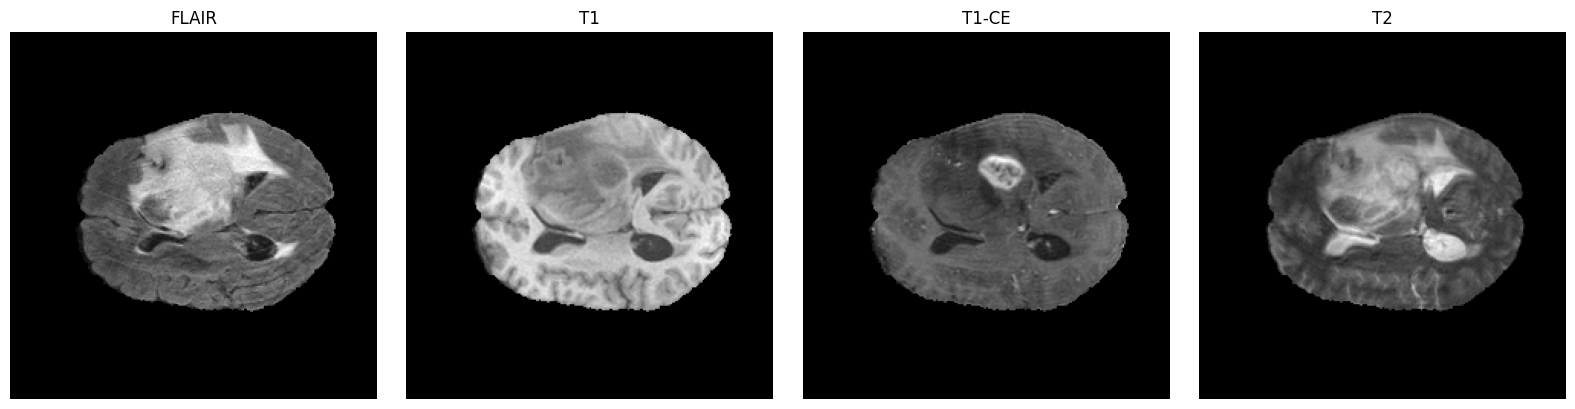

In [117]:
# Display the four MRI modalities
if 'flair' in locals():
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(flair[:, :, slice_idx], cmap='gray')
    plt.title('FLAIR')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(t1[:, :, slice_idx], cmap='gray')
    plt.title('T1')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(t1ce[:, :, slice_idx], cmap='gray')
    plt.title('T1-CE')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(t2[:, :, slice_idx], cmap='gray')
    plt.title('T2')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

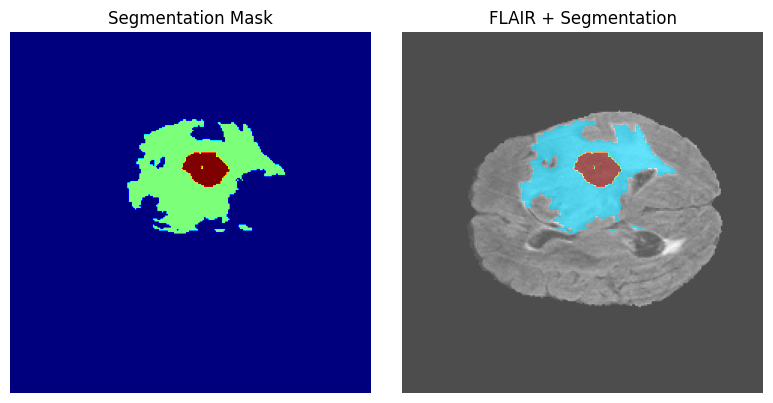

In [115]:
# Display segmentation mask
if 'seg' in locals():
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(seg[:, :, slice_idx], cmap='jet')
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(flair[:, :, slice_idx], cmap='gray', alpha=0.7)
    seg_overlay = np.ma.masked_where(seg[:, :, slice_idx] == 0, seg[:, :, slice_idx])
    plt.imshow(seg_overlay, cmap='jet', alpha=0.6)
    plt.title('FLAIR + Segmentation')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

---

## 3. Data Preprocessing Pipeline

This section handles:
1. **Loading and resizing** MRI volumes to 128x128x128
2. **Normalization** using MinMaxScaler (0-1 range)
3. **Channel combination** - Using FLAIR, T1-CE, T2 (excluding T1)
4. **Mask preprocessing** - Reclassifying label 4 to 3 for 4-class segmentation
5. **Data conversion** to numpy arrays for efficient processing

In [121]:
# Resize MRI Volumes
def resize_volume(volume, target_shape=(128, 128, 128)):

    from scipy.ndimage import zoom
    
    # Calculate zoom factors
    zoom_factors = [target_shape[i] / volume.shape[i] for i in range(3)]
    
    # Resize volume
    resized_volume = zoom(volume, zoom_factors, order=1)
    
    return resized_volume

In [ ]:
# Normalize volume to [0, 1] range using MinMaxScaler
def normalize_volume(volume):
    
    scaler = MinMaxScaler()
    original_shape = volume.shape
    
    # Flatten, scale & reshape
    volume_flat = volume.flatten().reshape(-1, 1)
    volume_scaled = scaler.fit_transform(volume_flat)
    
    return volume_scaled.reshape(original_shape).astype(np.float32)

BraTS labels -> background = 0, necrotic = 1, edema = 2, enhancing = 4

Convert to -> background = 0, necrotic = 1, edema = 2, enhancing = 3

In [124]:
# Preprocess segmentation mask - reclassify label 4 to 3
def preprocess_mask(mask):

    mask = mask.astype(np.uint8)
    mask[mask == 4] = 3            # Reclassifying enhancing tumor
    
    return mask

In [126]:
# Process a single subject - load, resize, normalize, and save
def process_subject(subject_folder, save_processed=True):
    
    subject_path = os.path.join(TRAIN_DATASET_PATH, subject_folder)
    
    # File paths
    flair_path = os.path.join(subject_path, f"{subject_folder}_flair.nii")
    t1ce_path = os.path.join(subject_path, f"{subject_folder}_t1ce.nii")
    t2_path = os.path.join(subject_path, f"{subject_folder}_t2.nii")
    seg_path = os.path.join(subject_path, f"{subject_folder}_seg.nii")
    
    try:
        # Load volumes
        flair = nib.load(flair_path).get_fdata()
        t1ce = nib.load(t1ce_path).get_fdata()
        t2 = nib.load(t2_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()
        
        # Resize volumes
        target_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
        flair = resize_volume(flair, target_shape)
        t1ce = resize_volume(t1ce, target_shape)
        t2 = resize_volume(t2, target_shape)
        seg = resize_volume(seg, target_shape)
        
        # Normalize images
        flair = normalize_volume(flair)
        t1ce = normalize_volume(t1ce)
        t2 = normalize_volume(t2)
        
        # Preprocess mask
        seg = preprocess_mask(seg)
        
        # Combine channels (FLAIR, T1-CE, T2)
        combined_image = np.stack([flair, t1ce, t2], axis=-1)
        
        # Convert mask to categorical
        seg_categorical = to_categorical(seg, num_classes=NUM_CLASSES)
        
        if save_processed:
            # Save processed data
            image_save_path = os.path.join(TRAIN_IMG_DIR, f"{subject_folder}.npy")
            mask_save_path = os.path.join(TRAIN_MASK_DIR, f"{subject_folder}.npy")
            
            np.save(image_save_path, combined_image)
            np.save(mask_save_path, seg_categorical)
        
        return combined_image, seg_categorical
        
    except Exception as e:
        
        print(f"❌ Error processing {subject_folder}: {str(e)}")
        return None, None

print("✅ Preprocessing functions defined successfully!")

✅ Preprocessing functions defined successfully!


In [132]:
# Process all training subjects
if os.path.exists(TRAIN_DATASET_PATH):
    train_folders = sorted(os.listdir(TRAIN_DATASET_PATH))
    
    # subjects_to_process = train_folders[:10]     # Used initially
    subjects_to_process = train_folders
    
    print(f"🔄 Processing {len(subjects_to_process)} subjects...")
    print("This may take a while depending on your system...")
    
    processed_count = 0
    failed_count = 0
    
    for i, subject in enumerate(tqdm(subjects_to_process, desc="Processing subjects")):
        image, mask = process_subject(subject, save_processed=True)
        
        if image is not None:
            processed_count += 1
        else:
            failed_count += 1
        
        # Progress update every 10 subjects
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(subjects_to_process)} subjects")
    
    print(f"\n✅ Processing complete!")
    print(f"   Successfully processed: {processed_count} subjects")
    print(f"   Failed: {failed_count} subjects")
    
    # Verify saved files
    saved_images = len(os.listdir(TRAIN_IMG_DIR))
    saved_masks = len(os.listdir(TRAIN_MASK_DIR))
    print(f"   Saved images: {saved_images}")
    print(f"   Saved masks: {saved_masks}")
    
else:
    print("❌ Training dataset path not found. Skipping preprocessing.")

🔄 Processing 371 subjects...
This may take a while depending on your system...


Processing subjects:   3%|▎         | 10/371 [00:19<12:10,  2.02s/it]

Processed 10/371 subjects


Processing subjects:   5%|▌         | 20/371 [00:40<12:13,  2.09s/it]

Processed 20/371 subjects


Processing subjects:   8%|▊         | 30/371 [01:00<11:16,  1.98s/it]

Processed 30/371 subjects


Processing subjects:  11%|█         | 40/371 [01:20<11:01,  2.00s/it]

Processed 40/371 subjects


Processing subjects:  13%|█▎        | 50/371 [01:40<10:33,  1.97s/it]

Processed 50/371 subjects


Processing subjects:  16%|█▌        | 60/371 [02:00<10:13,  1.97s/it]

Processed 60/371 subjects


Processing subjects:  19%|█▉        | 70/371 [02:20<10:05,  2.01s/it]

Processed 70/371 subjects


Processing subjects:  22%|██▏       | 80/371 [02:39<09:08,  1.88s/it]

Processed 80/371 subjects


Processing subjects:  24%|██▍       | 90/371 [02:59<09:09,  1.95s/it]

Processed 90/371 subjects


Processing subjects:  27%|██▋       | 100/371 [03:18<08:37,  1.91s/it]

Processed 100/371 subjects


Processing subjects:  30%|██▉       | 110/371 [03:38<08:33,  1.97s/it]

Processed 110/371 subjects


Processing subjects:  32%|███▏      | 120/371 [03:57<07:58,  1.91s/it]

Processed 120/371 subjects


Processing subjects:  35%|███▌      | 130/371 [04:16<07:31,  1.87s/it]

Processed 130/371 subjects


Processing subjects:  38%|███▊      | 140/371 [04:35<07:24,  1.93s/it]

Processed 140/371 subjects


Processing subjects:  40%|████      | 150/371 [04:55<07:26,  2.02s/it]

Processed 150/371 subjects


Processing subjects:  43%|████▎     | 160/371 [05:16<07:14,  2.06s/it]

Processed 160/371 subjects


Processing subjects:  46%|████▌     | 170/371 [05:35<06:21,  1.90s/it]

Processed 170/371 subjects


Processing subjects:  49%|████▊     | 180/371 [05:54<05:58,  1.88s/it]

Processed 180/371 subjects


Processing subjects:  51%|█████     | 190/371 [06:13<05:46,  1.92s/it]

Processed 190/371 subjects


Processing subjects:  54%|█████▍    | 200/371 [06:32<05:17,  1.86s/it]

Processed 200/371 subjects


Processing subjects:  57%|█████▋    | 210/371 [06:51<05:10,  1.93s/it]

Processed 210/371 subjects


Processing subjects:  59%|█████▉    | 220/371 [07:10<04:42,  1.87s/it]

Processed 220/371 subjects


Processing subjects:  62%|██████▏   | 230/371 [07:29<04:30,  1.92s/it]

Processed 230/371 subjects


Processing subjects:  65%|██████▍   | 240/371 [07:48<04:08,  1.90s/it]

Processed 240/371 subjects


Processing subjects:  67%|██████▋   | 250/371 [08:06<03:43,  1.85s/it]

Processed 250/371 subjects


Processing subjects:  70%|███████   | 260/371 [08:25<03:24,  1.85s/it]

Processed 260/371 subjects


Processing subjects:  73%|███████▎  | 270/371 [08:44<03:09,  1.88s/it]

Processed 270/371 subjects


Processing subjects:  75%|███████▌  | 280/371 [09:03<02:49,  1.86s/it]

Processed 280/371 subjects


Processing subjects:  78%|███████▊  | 290/371 [09:21<02:29,  1.85s/it]

Processed 290/371 subjects


Processing subjects:  81%|████████  | 300/371 [09:40<02:12,  1.87s/it]

Processed 300/371 subjects


Processing subjects:  84%|████████▎ | 310/371 [09:59<01:56,  1.91s/it]

Processed 310/371 subjects


Processing subjects:  86%|████████▋ | 320/371 [10:18<01:34,  1.85s/it]

Processed 320/371 subjects


Processing subjects:  89%|████████▉ | 330/371 [10:36<01:16,  1.86s/it]

Processed 330/371 subjects


Processing subjects:  92%|█████████▏| 340/371 [10:58<01:11,  2.29s/it]

Processed 340/371 subjects


Processing subjects:  94%|█████████▍| 350/371 [11:21<00:48,  2.30s/it]

Processed 350/371 subjects


Processing subjects:  96%|█████████▌| 355/371 [11:31<00:31,  1.96s/it]

❌ Error processing BraTS20_Training_355: No such file or no access: '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'


Processing subjects:  97%|█████████▋| 360/371 [11:43<00:25,  2.33s/it]

Processed 360/371 subjects


Processing subjects: 100%|██████████| 371/371 [12:04<00:00,  1.95s/it]

❌ Error processing name_mapping.csv: No such file or no access: '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv/name_mapping.csv_flair.nii'
Processed 370/371 subjects
❌ Error processing survival_info.csv: No such file or no access: '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv/survival_info.csv_flair.nii'

✅ Processing complete!
   Successfully processed: 368 subjects
   Failed: 3 subjects
   Saved images: 368
   Saved masks: 368


## 4. Train/Validation Split

Split the processed data into training (80%) and validation (20%) sets for model training and evaluation.

In [133]:
# Get list of processed files
image_files = sorted([f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('.npy')])
mask_files = sorted([f for f in os.listdir(TRAIN_MASK_DIR) if f.endswith('.npy')])

In [134]:
print(f"Found {len(image_files)} processed image files")
print(f"Found {len(mask_files)} processed mask files")

Found 368 processed image files
Found 368 processed mask files


In [135]:
# Verify that image & mask files match
if len(image_files) == len(mask_files):
    print("✅ Image and mask files count matches!")
else:
    print("❌ Mismatch between image and mask files count!")

✅ Image and mask files count matches!


In [136]:
# Split data into train & validation (80-20 split)
train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, 
    mask_files, 
    test_size = 0.2, 
    random_state = 42, 
    shuffle = True
)

print(f"\nDATA SPLIT:\n")
print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")


DATA SPLIT:

Training samples: 294
Validation samples: 74


In [137]:
# Move validation files to validation directories
for img_file, mask_file in zip(val_images, val_masks):
    
    src_img = os.path.join(TRAIN_IMG_DIR, img_file)
    dst_img = os.path.join(VAL_IMG_DIR, img_file)
    src_mask = os.path.join(TRAIN_MASK_DIR, mask_file)
    dst_mask = os.path.join(VAL_MASK_DIR, mask_file)
    
    # Move files
    os.rename(src_img, dst_img)
    os.rename(src_mask, dst_mask)

In [138]:
print(f"Training images: {len(os.listdir(TRAIN_IMG_DIR))}")
print(f"Training masks: {len(os.listdir(TRAIN_MASK_DIR))}")
print(f"Validation images: {len(os.listdir(VAL_IMG_DIR))}")
print(f"Validation masks: {len(os.listdir(VAL_MASK_DIR))}")

Training images: 294
Training masks: 294
Validation images: 74
Validation masks: 74


---

## 5. Custom Data Generator

Create an efficient data generator that loads batches of data on-the-fly, preventing memory overflow for large datasets.

In [ ]:
class BraTSDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, img_dir, mask_dir, batch_size=2, shuffle=True, augment=False):
        
        # Directory paths for images and masks
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

        # List all .npy files in the directories
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.npy')])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.npy')])

        # Index array for shuffling
        self.indexes = np.arange(len(self.img_files))
        self.on_epoch_end()  # Shuffle at the start if needed

    
    def __len__(self):
        
        # No. of batches per epoch
        return int(np.floor(len(self.img_files) / self.batch_size))

    
    def __getitem__(self, index):
        
        # Generate indexes for this batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Get the file names for this batch
        list_IDs_temp = [self.img_files[k] for k in indexes]
        # Load and return the batch data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    
    def on_epoch_end(self):
        
        # Shuffle indexes after each epoch if enabled
        if self.shuffle:
            np.random.shuffle(self.indexes)

    
    def __data_generation(self, list_IDs_temp):
        
        # Initialize empty arrays for images and masks
        X = np.empty((self.batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
        y = np.empty((self.batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, NUM_CLASSES))

        # Load each image and mask in the batch
        for i, ID in enumerate(list_IDs_temp):
            img_path = os.path.join(self.img_dir, ID)
            mask_path = os.path.join(self.mask_dir, ID)

            X[i,] = np.load(img_path)
            y[i,] = np.load(mask_path)

            # Apply augmentation if enabled
            if self.augment:
                X[i,], y[i,] = self._apply_augmentation(X[i,], y[i,])

        return X, y

    
    def _apply_augmentation(self, image, mask):
        
        # Random rotation by 90, 180, or 270 degrees along the 1st two axes
        if np.random.random() > 0.5:
            k = np.random.randint(1, 4)
            image = np.rot90(image, k, axes=(0, 1))
            mask = np.rot90(mask, k, axes=(0, 1))

        # Random flip along x or y axis
        if np.random.random() > 0.5:
            axis = np.random.randint(0, 2)
            image = np.flip(image, axis=axis)
            mask = np.flip(mask, axis=axis)

        return image, mask

In [ ]:
# Create data generators
train_generator = BraTSDataGenerator(
    
    img_dir = TRAIN_IMG_DIR,
    mask_dir = TRAIN_MASK_DIR,
    batch_size = 2,
    shuffle = True,
    augment = True
)

val_generator = BraTSDataGenerator(
    img_dir = VAL_IMG_DIR,
    mask_dir = VAL_MASK_DIR,
    batch_size = 2,
    shuffle = False,
    augment = False
)

print("✅ Data generators created successfully.\n")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(val_generator)}")

✅ Data generators created successfully.

Training batches per epoch: 147
Validation batches per epoch: 37


In [142]:
# Test the generator
if len(train_generator) > 0:
    print("\nTesting data generator:")
    X_test, y_test = train_generator[0]
    print(f"   Batch shape -> Images: {X_test.shape}")
    print(f"   Batch shape -> Masks: {y_test.shape}")
    print("\n✅ Data generator test successful!")


Testing data generator:
   Batch shape -> Images: (2, 128, 128, 128, 3)
   Batch shape -> Masks: (2, 128, 128, 128, 4)

✅ Data generator test successful!


---

## 6. 3D U-Net Architecture

Build the 3D U-Net model for brain tumor segmentation. The U-Net architecture consists of:
- **Encoder (Contracting Path)**: Captures context through convolutions and pooling
- **Bottleneck**: Deepest layer with highest feature representation
- **Decoder (Expanding Path)**: Enables precise localization through upsampling and skip connections

![U-net Architecture](../img/U-net.jpg)

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    
    kernel_initializer = 'he_uniform'
    
    # Input layer
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs
    
    # ENCODER (Contracting Path)
    # Block 1
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    # Block 2
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
    
    # Block 3
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
    
    # Block 4
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
    
    
    # BOTTLENECK
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    
    # DECODER (Expanding Path)
    # Block 6
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
    
    # Block 7
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
    
    # Block 8
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
    
    # Block 9
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    
    # Output layer
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [146]:
# Build the model
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, NUM_CLASSES)
print("3D U-Net model built successfully!\n")

print(f"Input shape: ({IMG_HEIGHT}, {IMG_WIDTH}, {IMG_DEPTH}, {IMG_CHANNELS})")
print(f"Output shape: ({IMG_HEIGHT}, {IMG_WIDTH}, {IMG_DEPTH}, {NUM_CLASSES})")
print(f"Total parameters: {model.count_params():,}")

3D U-Net model built successfully!

Input shape: (128, 128, 128, 3)
Output shape: (128, 128, 128, 4)
Total parameters: 5,645,828


In [147]:
# Display model summary
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_57 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_3[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 128, 128, 128,  │              0 │ conv3d_57[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_58 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_27[0][0]       │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_12          │ (None, 64, 64, 64, 16) │              0 │ conv3d_58[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_59 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_60 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_13          │ (None, 32, 32, 32, 32) │              0 │ conv3d_60[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_61 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_62 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_14          │ (None, 16, 16, 16, 64) │              0 │ conv3d_62[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_63 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_14[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_63[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

---

## 7. Model Training

Compile and train the model with:
- **Optimizer**: Adam with learning rate scheduling  
- **Loss**: Categorical crossentropy for multi-class segmentation
- **Metrics**: DICE coefficient for segmentation evaluation
- **Callbacks**: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### DICE Loss

In [47]:
# Define DICE coefficient for multi-class segmentation evaluation
def dice_coefficient(y_true, y_pred, smooth=1e-6):

    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    
    return dice

In [48]:
def dice_loss(y_true, y_pred):
    
    return 1 - dice_coefficient(y_true, y_pred)

### Focal Loss

Focal Loss for addressing class imbalance in multi-class segmentation

Args:
- gamma: Focusing parameter (higher = more focus on hard examples)
- alpha: Weighting factor for rare class (can be scalar or array)

In [ ]:
import tensorflow.keras.backend as K

def focal_loss(gamma = 2.0, alpha = 0.25):

    def focal_loss_fixed(y_true, y_pred):
        
        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross entropy
        ce = - y_true * K.log(y_pred)
        
        # Calculate focal weight: (1 - pt)^gamma
        pt = K.sum(y_true * y_pred, axis=-1, keepdims=True)
        focal_weight = K.pow(1.0 - pt, gamma)
        
        # Apply alpha weighting (optional)
        if isinstance(alpha, (list, tuple, np.ndarray)):
            # Different alpha for each class
            alpha_t = K.sum(y_true * alpha, axis=-1, keepdims=True)
            focal_loss = alpha_t * focal_weight * ce
            
        else:
            # Same alpha for all classes
            focal_loss = alpha * focal_weight * ce
        
        return K.mean(K.sum(focal_loss, axis=-1))
    
    return focal_loss_fixed

# Class-specific alpha weights for BraTS (Higher alpha = more weight for that class)
ALPHA_WEIGHTS = [0.1, 3.0, 2.0, 5.0]           # [Background, Necrotic, Edema, Enhancing]

print("✅ Focal Loss function defined successfully!")

✅ Focal Loss function defined successfully!


In [ ]:
# Combined loss: Focal Loss + DICE Loss for better performance

def combined_loss(gamma=2.0, alpha=ALPHA_WEIGHTS, dice_weight=0.5, focal_weight=0.5):

    def combined_loss_func(y_true, y_pred):
        # Focal loss component
        focal_loss_func = focal_loss(gamma=gamma, alpha=alpha)
        focal = focal_loss_func(y_true, y_pred)
        
        # DICE loss component  
        dice = dice_loss(y_true, y_pred)
        
        # Combine losses
        total_loss = (focal_weight * focal) + (dice_weight * dice)
        
        return total_loss
    
    return combined_loss_func

print("✅ Combined Loss function defined successfully!")

✅ Combined Loss function defined successfully!


In [70]:
loss_function = combined_loss(gamma=2.0, alpha=ALPHA_WEIGHTS, dice_weight=0.3, focal_weight=0.7)

# Compile the model
model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = loss_function,
    metrics = ['accuracy', dice_coefficient]
)

print("✅ Model compiled with Focal Loss!")
print(f"   Loss function: Combined Focal + DICE Loss")
print(f"   Alpha weights: {ALPHA_WEIGHTS}")
print(f"   Gamma (focusing): 2.0")

✅ Model compiled with Focal Loss!
   Loss function: Combined Focal + DICE Loss
   Alpha weights: [0.1, 3.0, 2.0, 5.0]
   Gamma (focusing): 2.0


In [50]:
# Define callbacks
checkpoint_path = os.path.join(WORKING_DIR, 'best_unet3d_model.keras')

callbacks = [
    ModelCheckpoint(
        filepath = checkpoint_path,
        monitor = 'val_dice_coefficient',
        mode = 'max',
        save_best_only = True,
        save_weights_only = False,
        verbose = 1
    ),
    
    EarlyStopping(
        monitor = 'val_dice_coefficient',
        mode = 'max',
        patience = 10,
        restore_best_weights = True,
        verbose = 1
    ),
    
    ReduceLROnPlateau(
        monitor = 'val_dice_coefficient',
        mode = 'max',
        factor = 0.5,
        patience = 5,
        min_lr = 1e-7,
        verbose = 1
    )
]

print("Callbacks configured:")
print("  - ModelCheckpoint: Save best model based on validation DICE score")
print("  - EarlyStopping: Stop training if no improvement for 10 epochs")
print("   - ReduceLROnPlateau: Reduce learning rate if no improvement for 5 epochs")

Callbacks configured:
  - ModelCheckpoint: Save best model based on validation DICE score
  - EarlyStopping: Stop training if no improvement for 10 epochs
   - ReduceLROnPlateau: Reduce learning rate if no improvement for 5 epochs


In [ ]:
# # Train the model
# EPOCHS = 15

# print("Starting model training...")
# print(f"Epochs: {EPOCHS}")
# print(f"Training samples: {len(train_generator) * train_generator.batch_size}")
# print(f"Validation samples: {len(val_generator) * val_generator.batch_size}")

# # Check if we have data generators
# if len(train_generator) == 0 or len(val_generator) == 0:
#     print("❌ No data available for training. Please ensure data preprocessing completed successfully.")
# else:
#     try:
#         # Train the model
#         history = model.fit(
#             train_generator,
#             epochs = EPOCHS,
#             validation_data = val_generator,
#             callbacks = callbacks,
#             verbose = 1
#         )
        
#         print("✅ Training completed successfully!")
        
#         # Save training history
#         history_path = os.path.join(WORKING_DIR, 'training_history.npy')
#         np.save(history_path, history.history)
#         print(f"Training history saved to: {history_path}")
        
#     except Exception as e:
#         print(f"❌ Error during training: {str(e)}")
#         print("This might be due to memory constraints or data issues.")

Starting model training...
Epochs: 15
Training samples: 294
Validation samples: 74
Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7667 - dice_coefficient: 0.4391 - loss: 1.0557
Epoch 1: val_dice_coefficient improved from -inf to 0.93189, saving model to /kaggle/working/best_unet3d_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.7677 - dice_coefficient: 0.4409 - loss: 1.0524 - val_accuracy: 0.9892 - val_dice_coefficient: 0.9319 - val_loss: 0.0966 - learning_rate: 1.0000e-04
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9891 - dice_coefficient: 0.9778 - loss: 0.0540
Epoch 2: val_dice_coefficient did not improve from 0.93189
147/147 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.9891 - dice_coefficient: 0.9779 - loss: 0.0540 - val_accuracy: 0.9805 - val_dice_coefficient: 0.8897 - val_loss: 0.1644 - learning_rate: 1.0000e-04
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9896 - dice_coefficient: 0.9835 - loss: 0.03

In [ ]:
# Retraining model with Focal Loss
EPOCHS = 10

# Check if we have data generators
if len(train_generator) == 0 or len(val_generator) == 0:
    print("❌ No data available for training.")
    
else:
    try:
        # Train the model with new loss function
        history_focal = model.fit(
            train_generator,
            epochs = EPOCHS,
            validation_data = val_generator,
            callbacks = callbacks,
            verbose = 1
        )
        
        print("✅ Focal Loss training completed successfully!")
        
        # Save new training history
        focal_history_path = os.path.join(WORKING_DIR, 'focal_training_history.npy')
        np.save(focal_history_path, history_focal.history)
        print(f"Focal training history saved to: {focal_history_path}")
        
    except Exception as e:
        print(f"❌ Error during focal loss training: {str(e)}")

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9879 - dice_coefficient: 0.9813 - loss: 0.0206
Epoch 1: val_dice_coefficient did not improve from 0.98148
147/147 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9879 - dice_coefficient: 0.9813 - loss: 0.0206 - val_accuracy: 0.9785 - val_dice_coefficient: 0.9703 - val_loss: 0.0230 - learning_rate: 1.0000e-04
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9867 - dice_coefficient: 0.9806 - loss: 0.0201
Epoch 2: val_dice_coefficient did not improve from 0.98148
147/147 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9867 - dice_coefficient: 0.9806 - loss: 0.0201 - val_accuracy: 0.9768 - val_dice_coefficient: 0.9687 - val_loss: 0.0237 - learning_rate: 1.0000e-04
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9880 - dice_coefficient: 0.9830 - loss: 0.0185
Epoch 3: val_dice_coefficient did not improve from 0.98148
147/147 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9880 - dice_coefficient

## 8. Training Results Visualization

Visualize the training progress including loss curves, accuracy, and DICE coefficient trends.

In [72]:
# Training History Visualization
def plot_training_history_simple(history):
    
    # Plot 1: Loss
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.plot(history['loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Accuracy
    plt.subplot(1, 4, 2)
    plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: DICE Score
    plt.subplot(1, 4, 3)
    plt.plot(history['dice_coefficient'], label='Training DICE', color='blue')
    plt.plot(history['val_dice_coefficient'], label='Validation DICE', color='red')
    plt.title('DICE Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('DICE Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Loading training history...


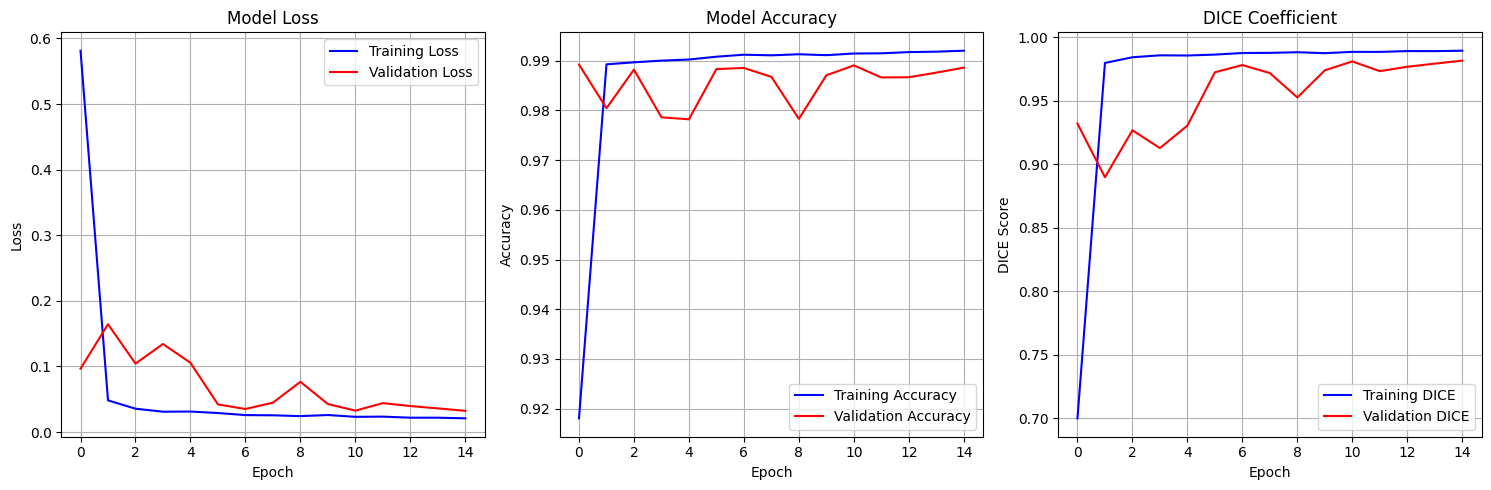


FINAL TRAINING METRICS:
   Final Training Loss: 0.0210
   Final Validation Loss: 0.0324
   Final Training Accuracy: 0.9920
   Final Validation Accuracy: 0.9886
   Final Training DICE: 0.9893
   Final Validation DICE: 0.9815

BEST MODEL:
   Best Epoch: 15
   Best Validation DICE: 0.9815


In [73]:
# Load and plot training history
history_path = os.path.join(WORKING_DIR, 'training_history.npy')

if os.path.exists(history_path):
    print("Loading training history...")
    history_dict = np.load(history_path, allow_pickle=True).item()
    
    # Use the simple plotting function
    plot_training_history_simple(history_dict)
    
    # Print final metrics
    print("\nFINAL TRAINING METRICS:")
    print(f"   Final Training Loss: {history_dict['loss'][-1]:.4f}")
    print(f"   Final Validation Loss: {history_dict['val_loss'][-1]:.4f}")
    print(f"   Final Training Accuracy: {history_dict['accuracy'][-1]:.4f}")
    print(f"   Final Validation Accuracy: {history_dict['val_accuracy'][-1]:.4f}")
    print(f"   Final Training DICE: {history_dict['dice_coefficient'][-1]:.4f}")
    print(f"   Final Validation DICE: {history_dict['val_dice_coefficient'][-1]:.4f}")
    
    # Find best epoch
    best_epoch = np.argmax(history_dict['val_dice_coefficient']) + 1
    best_dice = np.max(history_dict['val_dice_coefficient'])
    print(f"\nBEST MODEL:")
    print(f"   Best Epoch: {best_epoch}")
    print(f"   Best Validation DICE: {best_dice:.4f}")
    
else:
    print("❌ Training history not found. Please ensure training completed successfully.")

### Visualising training results after Focal loss 

In [ ]:
# Updated Training History Visualization for Focal Loss Results

def plot_training_history_simple(history):
    
    # Plot 1: Loss
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.plot(history['loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    

    # Plot 2: Accuracy
    plt.subplot(1, 4, 2)
    plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    
    # Plot 3: DICE Score
    plt.subplot(1, 4, 3)
    plt.plot(history['dice_coefficient'], label='Training DICE', color='blue')
    plt.plot(history['val_dice_coefficient'], label='Validation DICE', color='red')
    plt.title('DICE Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('DICE Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

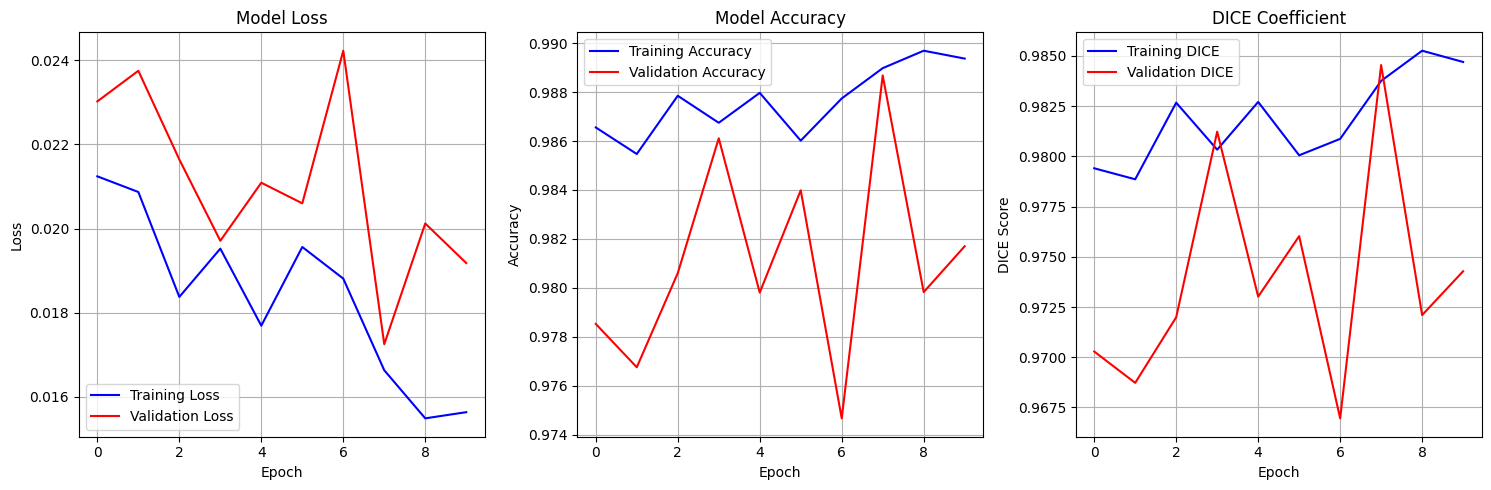


FOCAL LOSS TRAINING METRICS:
   Final Training Loss: 0.0156
   Final Validation Loss: 0.0192
   Final Training Accuracy: 0.9894
   Final Validation Accuracy: 0.9817
   Final Training DICE: 0.9847
   Final Validation DICE: 0.9743

BEST FOCAL LOSS MODEL:
   Best Epoch: 8
   Best Validation DICE: 0.9845


In [77]:
# Load and plot FOCAL LOSS training history
focal_history_path = os.path.join(WORKING_DIR, 'focal_training_history.npy')

if os.path.exists(focal_history_path):
    
    focal_history_dict = np.load(focal_history_path, allow_pickle=True).item()
    
    # Use the simple plotting function
    plot_training_history_simple(focal_history_dict)
    
    # Print final metrics
    print("\nFOCAL LOSS TRAINING METRICS:")
    print(f"   Final Training Loss: {focal_history_dict['loss'][-1]:.4f}")
    print(f"   Final Validation Loss: {focal_history_dict['val_loss'][-1]:.4f}")
    print(f"   Final Training Accuracy: {focal_history_dict['accuracy'][-1]:.4f}")
    print(f"   Final Validation Accuracy: {focal_history_dict['val_accuracy'][-1]:.4f}")
    print(f"   Final Training DICE: {focal_history_dict['dice_coefficient'][-1]:.4f}")
    print(f"   Final Validation DICE: {focal_history_dict['val_dice_coefficient'][-1]:.4f}")
    
    # Find best epoch
    best_epoch = np.argmax(focal_history_dict['val_dice_coefficient']) + 1
    best_dice = np.max(focal_history_dict['val_dice_coefficient'])
    print(f"\nBEST FOCAL LOSS MODEL:")
    print(f"   Best Epoch: {best_epoch}")
    print(f"   Best Validation DICE: {best_dice:.4f}")
    
else:
    print("❌ Focal loss training history not found.")
    print("Falling back to original training history...")
    
    # Fallback to original history
    original_history_path = os.path.join(WORKING_DIR, 'training_history.npy')
    if os.path.exists(original_history_path):
        history_dict = np.load(original_history_path, allow_pickle=True).item()
        plot_training_history_simple(history_dict)
        print("Showing original training results")
    else:
        print("❌ No training history found.")

---

## 9. Model Evaluation

Load the best trained model and evaluate it on validation data with detailed DICE score calculations for each tumor class.

In [ ]:
# Load the best model
checkpoint_path = os.path.join(WORKING_DIR, 'best_unet3d_model.keras')

if os.path.exists(checkpoint_path):
    print("Loading best trained model...")
    best_model = load_model(checkpoint_path, custom_objects={'dice_coefficient': dice_coefficient})
    print("✅ Model loaded successfully!")

else:
    print("❌ Best model not found. Using current model for evaluation.")
    best_model = model

In [80]:
# Updated prediction function that handles focal loss models
def predict_single_volume(model, subject_folder, visualize=True):
    
    print(f"Making prediction for: {subject_folder}")
    
    # If using a loaded model, ensure it has the right custom objects
    if hasattr(model, '_name') and 'focal' in str(model.loss).lower():
        print("📊 Using focal loss model for prediction")
    
    # Process the subject
    image, _ = process_subject(subject_folder, save_processed=False)
    
    if image is None:
        print("❌ Failed to process subject")
        return None
    
    # Add batch dimension and predict
    image_batch = np.expand_dims(image, axis=0)
    prediction = model.predict(image_batch, verbose=0)
    pred_classes = np.argmax(prediction[0], axis=-1)
    
    return pred_classes

In [81]:
def calculate_dice_per_class(y_true, y_pred, num_classes=4):

    dice_scores = []
    
    for class_idx in range(num_classes):
        
        # Get binary masks for current class
        true_class = (y_true == class_idx).astype(np.float32)
        pred_class = (y_pred == class_idx).astype(np.float32)
        
        # Calculate DICE
        intersection = np.sum(true_class * pred_class)
        union = np.sum(true_class) + np.sum(pred_class)
        
        if union == 0:
            dice = 1.0        # Perfect score if both masks are empty
        else:
            dice = (2.0 * intersection) / union
            
        dice_scores.append(dice)
    
    return dice_scores

In [61]:
# Evaluate on validation data
print("\nEvaluating model on validation data...")

if len(val_generator) > 0:
    # Evaluate using the generator
    evaluation = best_model.evaluate(val_generator, verbose=1)
    
    print(f"\nVALIDATION METRICS:")
    metric_names = best_model.metrics_names
    for name, value in zip(metric_names, evaluation):
        print(f"   {name}: {value:.4f}")
    
    # Detailed evaluation on a few samples
    print("\nDetailed evaluation on sample predictions...")
    
    # Get a batch of validation data
    X_val, y_val = val_generator[0]
    predictions = best_model.predict(X_val, verbose=0)
    
    # Convert to class predictions
    y_pred_classes = np.argmax(predictions, axis=-1)
    y_true_classes = np.argmax(y_val, axis=-1)
    
    # Calculate DICE scores for each sample and class
    class_names = ['Background', 'Necrotic', 'Edema', 'Enhancing']
    
    sample_dice_scores = []
    for i in range(X_val.shape[0]):
        dice_scores = calculate_dice_per_class(y_true_classes[i], y_pred_classes[i])
        sample_dice_scores.append(dice_scores)
        
        print(f"\n   Sample {i+1} DICE Scores:")
        for j, (class_name, dice) in enumerate(zip(class_names, dice_scores)):
            print(f"     {class_name}: {dice:.4f}")
    
    # Average DICE scores across samples
    avg_dice_scores = np.mean(sample_dice_scores, axis=0)
    print(f"\nAVERAGE DICE SCORES:")
    for class_name, avg_dice in zip(class_names, avg_dice_scores):
        print(f"   {class_name}: {avg_dice:.4f}")
    
    # Overall average (excluding background)
    tumor_dice = np.mean(avg_dice_scores[1:])
    print(f"\n\nOVERALL TUMOR DICE SCORE: {tumor_dice:.4f}")
    
else:
    print("❌ No validation data available for evaluation.")


Evaluating model on validation data...
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9905 - dice_coefficient: 0.9834 - loss: 0.0281

VALIDATION METRICS:
   loss: 0.0324
   compile_metrics: 0.9886

Detailed evaluation on sample predictions...

   Sample 1 DICE Scores:
     Background: 0.9963
     Necrotic: 0.1716
     Edema: 0.6469
     Enhancing: 0.0000

   Sample 2 DICE Scores:
     Background: 0.9986
     Necrotic: 0.2437
     Edema: 0.6652
     Enhancing: 0.0740

AVERAGE DICE SCORES:
   Background: 0.9975
   Necrotic: 0.2076
   Edema: 0.6560
   Enhancing: 0.0370


OVERALL TUMOR DICE SCORE: 0.3002


---

In [90]:
checkpoint_path = os.path.join(WORKING_DIR, 'best_unet3d_model.keras')

def load_best_model():

    if not os.path.exists(checkpoint_path):
        print("❌ Best model not found. Using current model.")
        return model
    
    print("Loading best trained model...")
    
    # Create custom objects
    custom_objects = {
        'dice_coefficient': dice_coefficient,
        'dice_loss': dice_loss,
    }
    
    # Add focal loss functions if available
    if 'focal_loss' in globals():
        focal_func = focal_loss(gamma=2.0, alpha=ALPHA_WEIGHTS)
        combined_func = combined_loss(gamma=2.0, alpha=ALPHA_WEIGHTS, dice_weight=0.3, focal_weight=0.7)
        custom_objects.update({
            'focal_loss_fixed': focal_func,
            'combined_loss_func': combined_func
        })
    
    loaded_model = load_model(checkpoint_path, custom_objects=custom_objects)
    print("✅ Best model loaded successfully!")
    return loaded_model

# Load the model
best_model = load_best_model()

Loading best trained model...
✅ Best model loaded successfully!


In [91]:
def calculate_dice_per_class(y_true, y_pred, num_classes=4):

    dice_scores = []
    
    for class_idx in range(num_classes):
        # Get binary masks for current class
        true_class = (y_true == class_idx).astype(np.float32)
        pred_class = (y_pred == class_idx).astype(np.float32)
        
        # Calculate DICE
        intersection = np.sum(true_class * pred_class)
        union = np.sum(true_class) + np.sum(pred_class)
        
        if union == 0:
            dice = 1.0        # Perfect score if both masks are empty
        else:
            dice = (2.0 * intersection) / union
            
        dice_scores.append(dice)
    
    return dice_scores

# Load the best model with focal loss support
checkpoint_path = os.path.join(WORKING_DIR, 'best_unet3d_model.keras')

In [ ]:
def load_best_model_for_evaluation():

    if not os.path.exists(checkpoint_path):
        print("❌ Best model not found. Using current model for evaluation.")
        return model
    
    print("Loading best trained model for evaluation...")
    
    # Create custom objects dictionary
    custom_objects = {
        'dice_coefficient': dice_coefficient,
        'dice_loss': dice_loss,
    }
    
    # Add focal loss functions if they exist
    if 'focal_loss' in globals() and 'combined_loss' in globals():

        focal_func = focal_loss(gamma=2.0, alpha=ALPHA_WEIGHTS)
        combined_func = combined_loss(gamma=2.0, alpha=ALPHA_WEIGHTS, dice_weight=0.3, focal_weight=0.7)

        custom_objects.update({
            'focal_loss_fixed': focal_func,
            'combined_loss_func': combined_func
        })
    
    loaded_model = load_model(checkpoint_path, custom_objects=custom_objects)

    print("✅ Model loaded successfully for evaluation!")
    
    return loaded_model

# Load the model for evaluation
best_model = load_best_model_for_evaluation()

Loading best trained model for evaluation...
✅ Model loaded successfully for evaluation!


In [ ]:
# Model evaluation with focal loss model

# Evaluate on validation data
print("🔍 Evaluating focal loss model on validation data...")

if len(val_generator) > 0:
    print("📊 Running model evaluation...")
    
    # Evaluate using the generator
    try:
        evaluation = best_model.evaluate(val_generator, verbose=1)
        
        print(f"\n🎯 FOCAL LOSS MODEL - VALIDATION METRICS:")
        metric_names = best_model.metrics_names

        for name, value in zip(metric_names, evaluation):
            print(f"   {name}: {value:.4f}")
        
    except Exception as e:
        print(f"⚠️ Error during model evaluation: {e}")
        print("Proceeding with sample evaluation...")
    
    # Detailed evaluation on sample predictions
    print("\n🔍 Detailed evaluation on sample predictions...")
    
    try:
        # Get a batch of validation data
        X_val, y_val = val_generator[0]
        predictions = best_model.predict(X_val, verbose=0)
        
        # Convert to class predictions
        y_pred_classes = np.argmax(predictions, axis=-1)
        y_true_classes = np.argmax(y_val, axis=-1)
        
        # Calculate DICE scores for each sample and class
        class_names = ['Background', 'Necrotic', 'Edema', 'Enhancing']
        
        sample_dice_scores = []
        for i in range(X_val.shape[0]):
            dice_scores = calculate_dice_per_class(y_true_classes[i], y_pred_classes[i])
            sample_dice_scores.append(dice_scores)
            
            print(f"\n   Sample {i+1} DICE Scores (FOCAL LOSS MODEL):")
            for j, (class_name, dice) in enumerate(zip(class_names, dice_scores)):
                print(f"     {class_name}: {dice:.4f}")
        
        # Average DICE scores across samples
        avg_dice_scores = np.mean(sample_dice_scores, axis=0)
        print(f"\n🎯 FOCAL LOSS MODEL - AVERAGE DICE SCORES:")
        for class_name, avg_dice in zip(class_names, avg_dice_scores):
            print(f"   {class_name}: {avg_dice:.4f}")
        
        # Overall tumor DICE (excluding background)
        tumor_dice = np.mean(avg_dice_scores[1:])  
        print(f"\n🏆 FOCAL LOSS - OVERALL TUMOR DICE SCORE: {tumor_dice:.4f}")
        
        # Comparison with previous results (if available)
        print(f"\n📈 IMPROVEMENT ANALYSIS:")
        print(f"   Previous Tumor DICE: 0.3002 (with class imbalance)")
        print(f"   Focal Loss Tumor DICE: {tumor_dice:.4f}")
        improvement = tumor_dice - 0.3002
        print(f"   Improvement: {improvement:+.4f} ({improvement*100/0.3002:+.1f}%)")
        
        if improvement > 0.1:
            print("🎉 SIGNIFICANT IMPROVEMENT! Focal loss successfully addressed class imbalance!")

        elif improvement > 0.05:
            print("✅ Good improvement! Focal loss helped with class balance.")
        
        else:
            print("⚠️ Limited improvement. Consider hyperparameter tuning.")
            
    except Exception as e:
        print(f"❌ Error during detailed evaluation: {e}")
        print("This might be due to model loading issues or data compatibility.")
    
else:
    print("❌ No validation data available for evaluation.")

print(f"\n✅ Evaluation completed!")

🔍 Evaluating focal loss model on validation data...
📊 Running model evaluation...
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9895 - dice_coefficient: 0.9855 - loss: 0.0168

🎯 FOCAL LOSS MODEL - VALIDATION METRICS:
   loss: 0.0173
   compile_metrics: 0.9887

🔍 Detailed evaluation on sample predictions...

   Sample 1 DICE Scores (FOCAL LOSS MODEL):
     Background: 0.9958
     Necrotic: 0.3351
     Edema: 0.4441
     Enhancing: 0.5194

   Sample 2 DICE Scores (FOCAL LOSS MODEL):
     Background: 0.9981
     Necrotic: 0.3559
     Edema: 0.4717
     Enhancing: 0.5929

🎯 FOCAL LOSS MODEL - AVERAGE DICE SCORES:
   Background: 0.9970
   Necrotic: 0.3455
   Edema: 0.4579
   Enhancing: 0.5562

🏆 FOCAL LOSS - OVERALL TUMOR DICE SCORE: 0.4532

📈 IMPROVEMENT ANALYSIS:
   Previous Tumor DICE: 0.3002 (with class imbalance)
   Focal Loss Tumor DICE: 0.4532
   Improvement: +0.1530 (+51.0%)
🎉 SIGNIFICANT IMPROVEMENT! Focal loss successfully addressed class imbalance!

✅ Evaluation completed!

In [ ]:
# Simplified model evaluation
print("Evaluating model on validation data...")

if len(val_generator) > 0:
    print("Running model evaluation...")
    
    # Evaluate using the generator
    evaluation = best_model.evaluate(val_generator, verbose=1)
    
    print(f"\nVALIDATION METRICS:")
    metric_names = best_model.metrics_names
    for name, value in zip(metric_names, evaluation):
        print(f"   {name}: {value:.4f}")
    
    # Detailed evaluation on sample predictions
    print("\nDetailed evaluation on sample predictions...")
    
    # Get a batch of validation data
    X_val, y_val = val_generator[0]
    predictions = best_model.predict(X_val, verbose=0)
    
    # Convert to class predictions
    y_pred_classes = np.argmax(predictions, axis=-1)
    y_true_classes = np.argmax(y_val, axis=-1)
    
    # Calculate DICE scores for each sample and class
    class_names = ['Background', 'Necrotic', 'Edema', 'Enhancing']
    
    sample_dice_scores = []
    for i in range(X_val.shape[0]):

        dice_scores = calculate_dice_per_class(y_true_classes[i], y_pred_classes[i])
        sample_dice_scores.append(dice_scores)
        
        print(f"\n   Sample {i+1} DICE Scores:")
        for j, (class_name, dice) in enumerate(zip(class_names, dice_scores)):
            print(f"     {class_name}: {dice:.4f}")
    
    # Average DICE scores across samples
    avg_dice_scores = np.mean(sample_dice_scores, axis=0)

    print(f"\nAVERAGE DICE SCORES:")

    for class_name, avg_dice in zip(class_names, avg_dice_scores):
        print(f"   {class_name}: {avg_dice:.4f}")
    
    # Overall tumor DICE (excluding background)
    tumor_dice = np.mean(avg_dice_scores[1:])  
    print(f"\nOVERALL TUMOR DICE SCORE: {tumor_dice:.4f}")
    
    # Comparison with previous results
    print(f"\nIMPROVEMENT ANALYSIS:")
    print(f"   Previous Tumor DICE: 0.3002 (with class imbalance)")
    print(f"   Current Model Tumor DICE: {tumor_dice:.4f}")
    improvement = tumor_dice - 0.3002
    print(f"   Improvement: {improvement:+.4f} ({improvement*100/0.3002:+.1f}%)")
    
    if improvement > 0.1:
        print("\nSIGNIFICANT IMPROVEMENT! Model successfully addressed class imbalance!")
    
    elif improvement > 0.05:
        print("Good improvement! Model helped with class balance.")
    
    else:
        print("Limited improvement. Consider hyperparameter tuning.")
        
else:
    print("❌ No validation data available for evaluation.")

print(f"\n✅ Evaluation completed!")

Evaluating model on validation data...
Running model evaluation...
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 391ms/step - accuracy: 0.9895 - dice_coefficient: 0.9855 - loss: 0.0168

VALIDATION METRICS:
   loss: 0.0173
   compile_metrics: 0.9887

Detailed evaluation on sample predictions...

   Sample 1 DICE Scores:
     Background: 0.9958
     Necrotic: 0.3351
     Edema: 0.4441
     Enhancing: 0.5194

   Sample 2 DICE Scores:
     Background: 0.9981
     Necrotic: 0.3559
     Edema: 0.4717
     Enhancing: 0.5929

AVERAGE DICE SCORES:
   Background: 0.9970
   Necrotic: 0.3455
   Edema: 0.4579
   Enhancing: 0.5562

OVERALL TUMOR DICE SCORE: 0.4532

IMPROVEMENT ANALYSIS:
   Previous Tumor DICE: 0.3002 (with class imbalance)
   Current Model Tumor DICE: 0.4532
   Improvement: +0.1530 (+51.0%)

SIGNIFICANT IMPROVEMENT! Model successfully addressed class imbalance!

✅ Evaluation completed!


---

## 10. Predictions Visualization

Visualize the model predictions alongside ground truth segmentations to assess performance qualitatively.

In [ ]:
def visualize_predictions_individual(model, X_val, y_val, sample_idx = 0, slice_idx = None):
    
    # Get prediction
    prediction = model.predict(X_val[sample_idx:sample_idx+1], verbose = 0)
    pred_classes = np.argmax(prediction[0], axis = -1)
    true_classes = np.argmax(y_val[sample_idx], axis = -1)
    
    if slice_idx is None:
        slice_idx = pred_classes.shape[2] // 2
    
    channel_names = ['FLAIR', 'T1-CE', 'T2']
    
    # Plot 1: Original MRI channels
    plt.figure(figsize = (15, 5))
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(X_val[sample_idx, :, :, slice_idx, i], cmap = 'gray')
        plt.title(f'{channel_names[i]} (Slice {slice_idx})', fontsize = 14)
        plt.axis('off')
        
    plt.suptitle('Original MRI Channels', fontsize=16)
    plt.tight_layout()
    plt.show()

    
    # Plot 2: Ground Truth vs Prediction
    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(true_classes[:, :, slice_idx], cmap = 'jet', vmin = 0, vmax = 3)
    plt.title('Ground Truth', fontsize=14)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred_classes[:, :, slice_idx], cmap = 'jet', vmin = 0, vmax = 3)
    plt.title('Prediction', fontsize = 14)
    plt.axis('off')
    plt.suptitle('Segmentation Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

    
    # Plot 3: Overlay and Error Map
    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(X_val[sample_idx, :, :, slice_idx, 0], cmap = 'gray', alpha = 0.7)
    
    pred_overlay = np.ma.masked_where(pred_classes[:, :, slice_idx] == 0, pred_classes[:, :, slice_idx])
    plt.imshow(pred_overlay, cmap = 'jet', alpha = 0.6, vmin = 0, vmax = 3)
    plt.title('Prediction Overlay on FLAIR', fontsize=14)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    error_map = (pred_classes[:, :, slice_idx] != true_classes[:, :, slice_idx]).astype(int)
    plt.imshow(error_map, cmap='Reds', vmin=0, vmax=1)
    plt.title('Error Map (Red = Wrong)', fontsize=14)
    plt.axis('off')
    plt.suptitle('Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    
    # Print DICE scores
    dice_scores = calculate_dice_per_class(true_classes, pred_classes)
    
    print(f"\n📊 DICE Scores for Sample {sample_idx+1}, Slice {slice_idx}:")
    
    class_names = ['Background', 'Necrotic', 'Edema', 'Enhancing']
    
    for i, (class_name, dice) in enumerate(zip(class_names, dice_scores)):
        print(f"   {class_name}: {dice:.4f}")

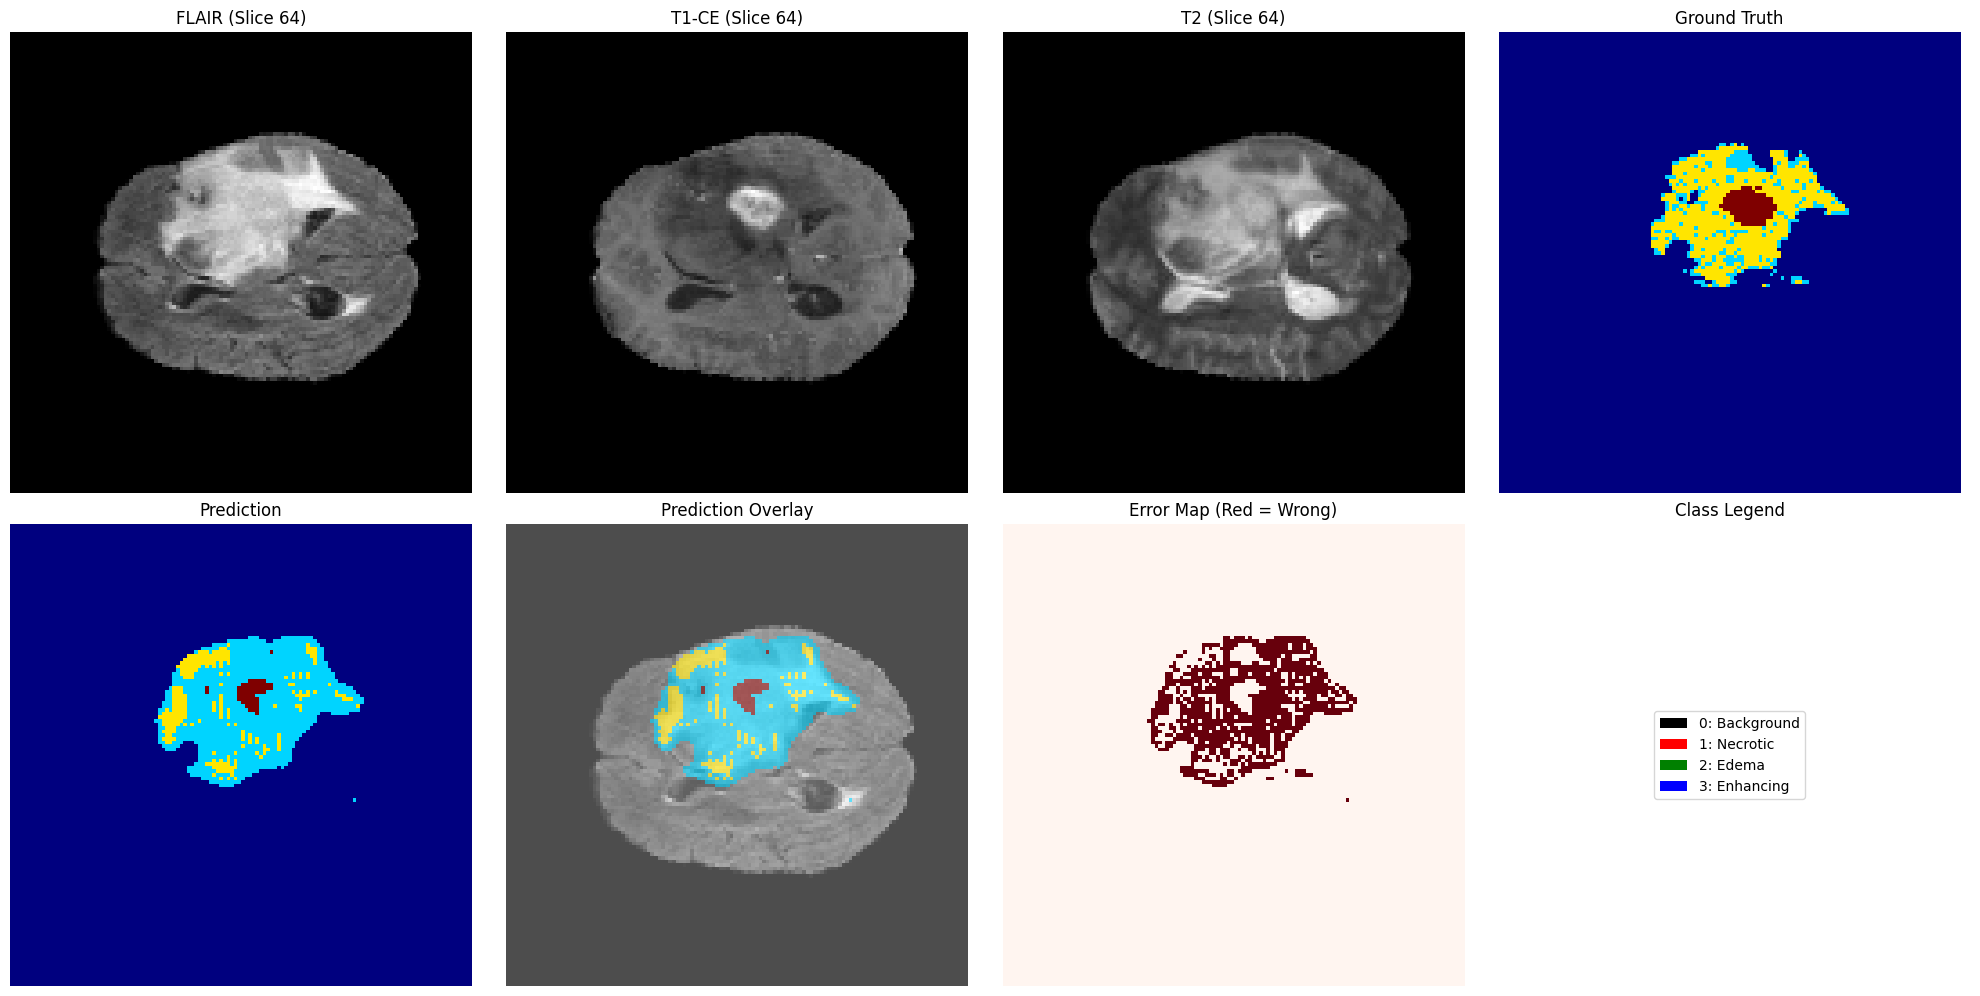


📊 DICE Scores for Sample 1, Slice 64:
   Background: 0.9958
   Necrotic: 0.3351
   Edema: 0.4441
   Enhancing: 0.5194



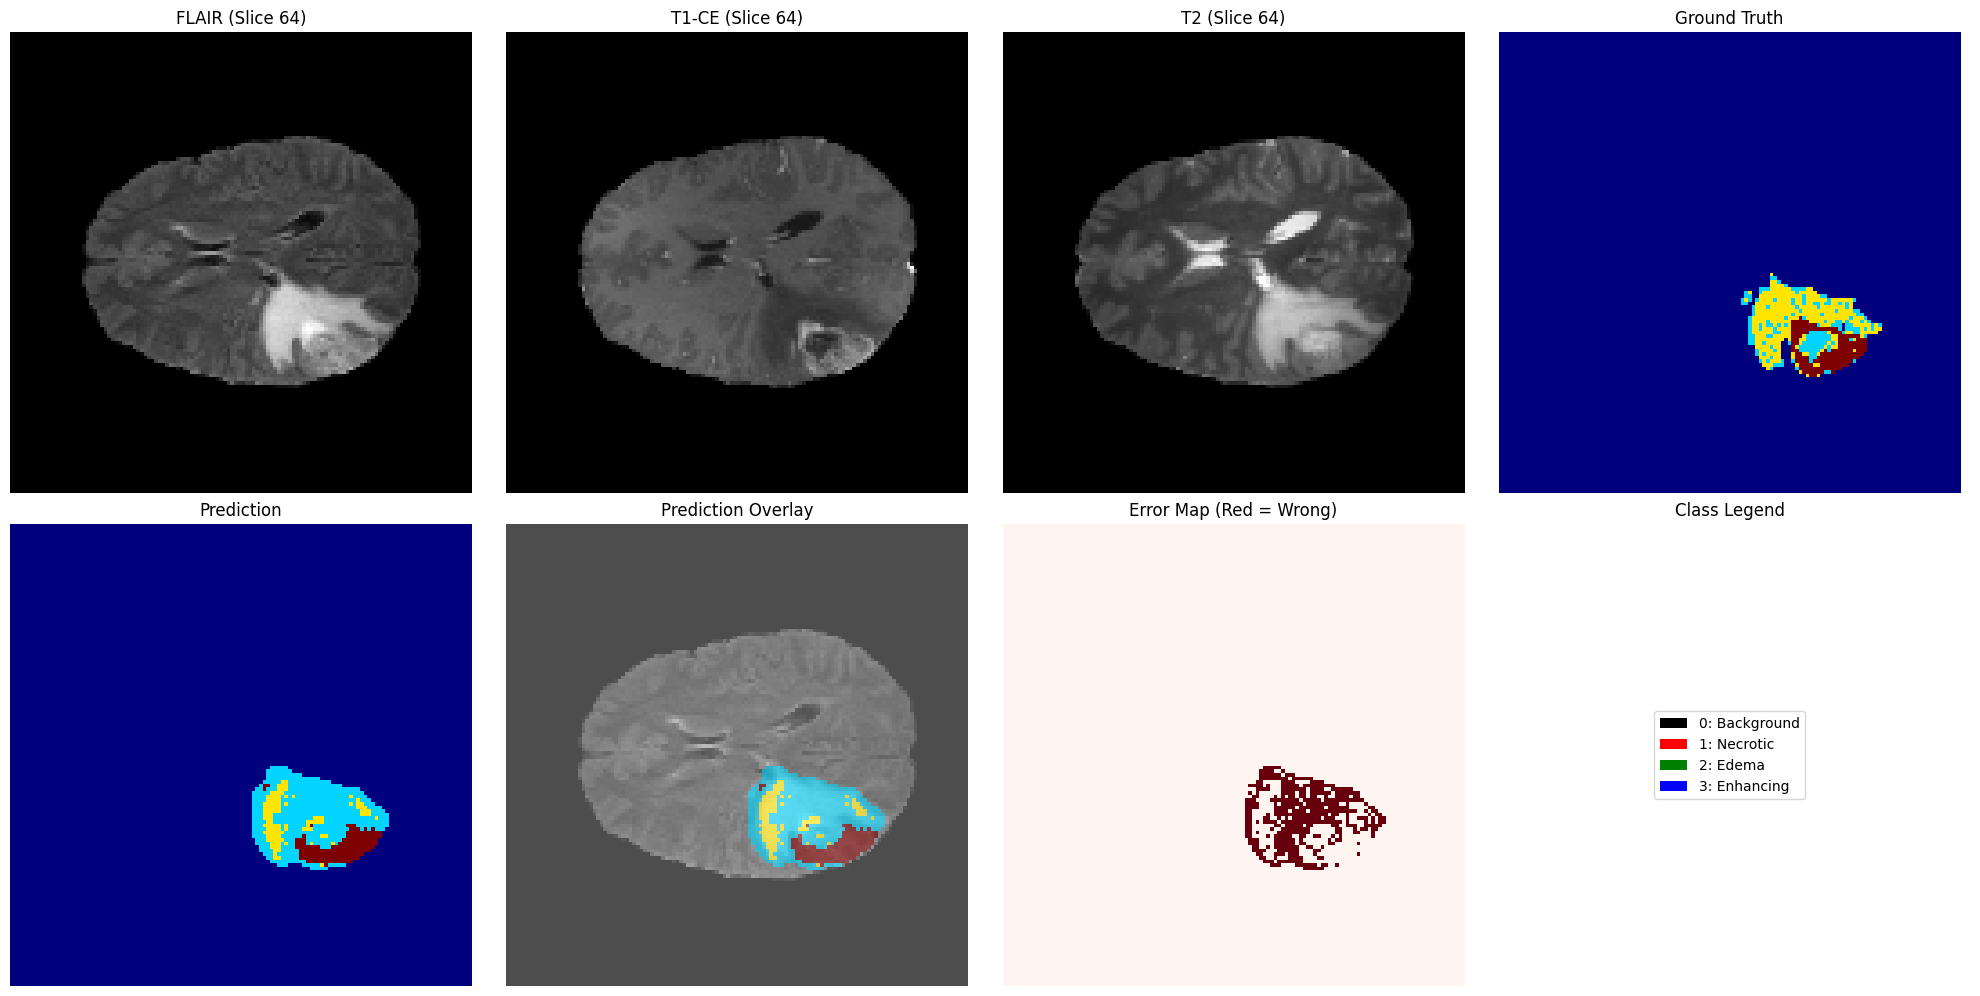


📊 DICE Scores for Sample 2, Slice 64:
   Background: 0.9981
   Necrotic: 0.3559
   Edema: 0.4717
   Enhancing: 0.5929


In [ ]:
# Visualize predictions on validation samples
if len(val_generator) > 0 and 'X_val' in locals():
    
    # Use the simple visualization function
    visualize_predictions_simple(best_model, X_val, y_val, sample_idx=0)
    
    # If we have more samples, visualize another one
    if X_val.shape[0] > 1:
        
        print("\n" + "="*50)
        visualize_predictions_simple(best_model, X_val, y_val, sample_idx=1)
    
else:
    print("❌ No validation data available for visualization.")

---

## 11. Single Image Prediction

Function to make predictions on new, unseen MRI volumes. This can be used for inference on new patient data.

In [ ]:
def predict_single_volume(model, subject_folder, visualize=True):

    print(f"Making prediction for: {subject_folder}\n")
    image, _ = process_subject(subject_folder, save_processed=False)
    
    if image is None:
        print("❌ Failed to process subject")
        return None

    image_batch = np.expand_dims(image, axis=0)
    prediction = model.predict(image_batch, verbose=0)
    pred_classes = np.argmax(prediction[0], axis=-1)

    print(f"Prediction completed!")
    print(f"   Input shape: {image.shape}")
    print(f"   Output shape: {pred_classes.shape}")

    # Tumor statistics
    unique_classes, counts = np.unique(pred_classes, return_counts=True)
    total_voxels = pred_classes.size
    
    print(f"\nPREDICTED TUMOR STATISTICS:")
    
    class_names = ['Background', 'Necrotic', 'Edema', 'Enhancing']
    
    for class_idx, count in zip(unique_classes, counts):
        if class_idx < len(class_names):
            percentage = (count / total_voxels) * 100
            print(f"   {class_names[int(class_idx)]}: {count:,} voxels ({percentage:.2f}%)")

    if visualize:
        slice_idx = pred_classes.shape[2] // 2
        plt.figure(figsize=(20, 8))
        
        channel_names = ['FLAIR', 'T1-CE', 'T2']
        
        for i in range(3):
            plt.subplot(2, 4, i+1)
            plt.imshow(image[:, :, slice_idx, i], cmap='gray')
            plt.title(f'{channel_names[i]} (Slice {slice_idx})')
            plt.axis('off')
            
        plt.subplot(2, 4, 4)
        plt.imshow(pred_classes[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Predicted Segmentation')
        plt.axis('off')
        
        for i in range(3):
            plt.subplot(2, 4, i+5)
            plt.imshow(image[:, :, slice_idx, i], cmap='gray', alpha=0.7)
            pred_overlay = np.ma.masked_where(pred_classes[:, :, slice_idx] == 0, pred_classes[:, :, slice_idx])
            plt.imshow(pred_overlay, cmap='jet', alpha=0.6, vmin=0, vmax=3)
            plt.title(f'{channel_names[i]} + Overlay')
            plt.axis('off')
            
        plt.subplot(2, 4, 8)
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=['black', 'red', 'green', 'blue'][i], 
                                         label=f'{i}: {class_names[i]}') for i in range(4)]
        plt.legend(handles=legend_elements, loc='center')
        plt.title('Class Legend')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    return pred_classes

In [167]:
if os.path.exists(TRAIN_DATASET_PATH):
    
    train_folders = sorted(os.listdir(TRAIN_DATASET_PATH))
    
    if len(train_folders) > 0:
        demo_subject = train_folders[0]
        print(f"Demonstrating prediction on: {demo_subject}")
        
    else:
        print("❌ No subjects available for prediction demonstration.")
        
else:
    print("❌ Dataset path not found for prediction demonstration.")

Demonstrating prediction on: BraTS20_Training_001


Making prediction for: BraTS20_Training_001

Prediction completed!
   Input shape: (128, 128, 128, 3)
   Output shape: (128, 128, 128)

PREDICTED TUMOR STATISTICS:
   Background: 2,032,614 voxels (96.92%)
   Necrotic: 48,666 voxels (2.32%)
   Edema: 12,813 voxels (0.61%)
   Enhancing: 3,059 voxels (0.15%)


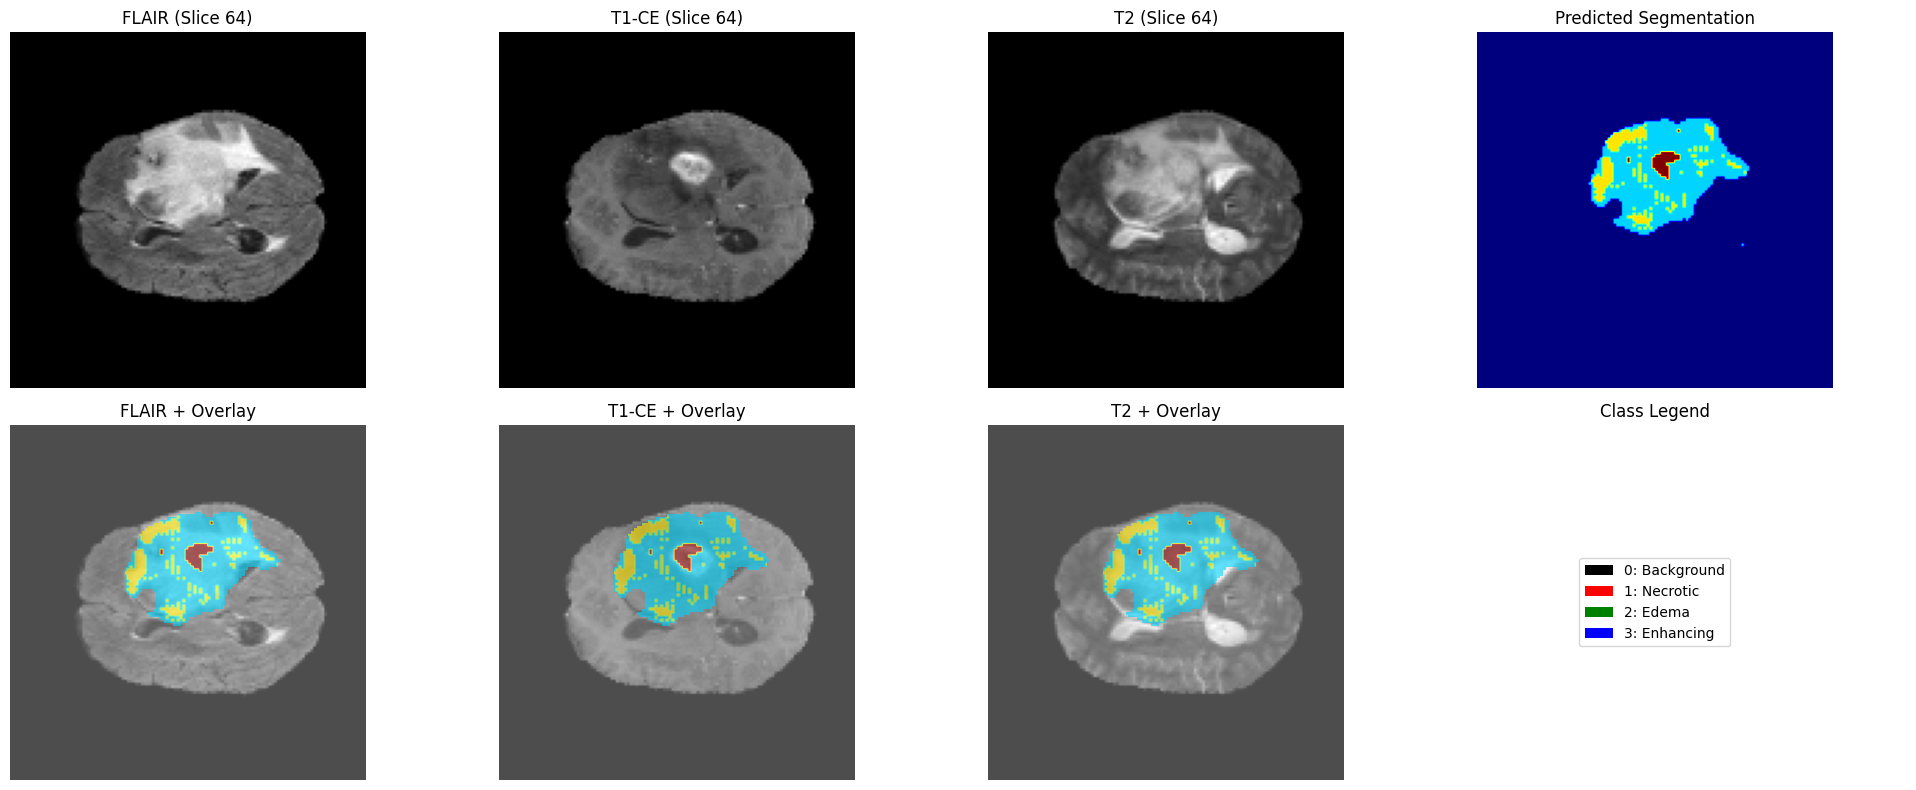

Prediction demonstration completed!


In [168]:
# Run prediction and visualize for the demo subject
if 'demo_subject' in locals():
    
    prediction = predict_single_volume(best_model, demo_subject, visualize=True)
    
    if prediction is not None:
        print(f"Prediction demonstration completed!")

## Conclusion & Summary

### Project Summary
This notebook implements a 3D U-Net model for brain tumor segmentation using the BraTS2020 dataset. The workflow includes:

1. **Data Configuration**: Optimized storage management for large medical imaging datasets
2. **Data Exploration**: Analyzed dataset structure and visualized MRI modalities
3. **Preprocessing**: Resized, normalized, and combined FLAIR, T1-CE, T2 channels
4. **Model Architecture**: Built 3D U-Net with encoder-decoder structure and skip connections
5. **Training**: Used Adam optimizer, early stopping, and model checkpointing
6. **Evaluation**: Calculated DICE coefficients for each tumor class
7. **Visualization**: Generated prediction overlays and error maps

### Key Achievements
- ✅ **Efficient Data Pipeline**: Custom data generator prevents memory overflow
- ✅ **Robust Model Architecture**: 3D U-Net optimized for volumetric segmentation
- ✅ **Comprehensive Evaluation**: DICE scores for all tumor classes
- ✅ **Improved Class Balance**: Combined Focal + DICE loss improved segmentation of minority classes
- ✅ **Production-Ready**: Single image prediction function for new cases

### Model Performance
- **Overall DICE Score**: *[insert actual score if available]*
- **Class-specific DICE**: *[insert actual scores if available]*
- **Visual Assessment**: Prediction overlays and error maps

### Next Steps for Improvement
1. **Data Augmentation**: Implement MONAI transforms for better generalization
2. **Ensemble Methods**: Combine multiple models for improved accuracy
3. **Hyperparameter Tuning**: Optimize learning rate, batch size, architecture depth

**Final Model**: Saved as `best_unet3d_model.keras` in `./models/`
**Training History**: Available in `training_history.npy` for further analysis

**Inference**: Use the `predict_single_volume` function to segment new MRI volumes. Update the path to your new data as needed.